On the training set: Mean Absolute Error = 28.42
On the testing set: Mean Absolute Error = 39.80


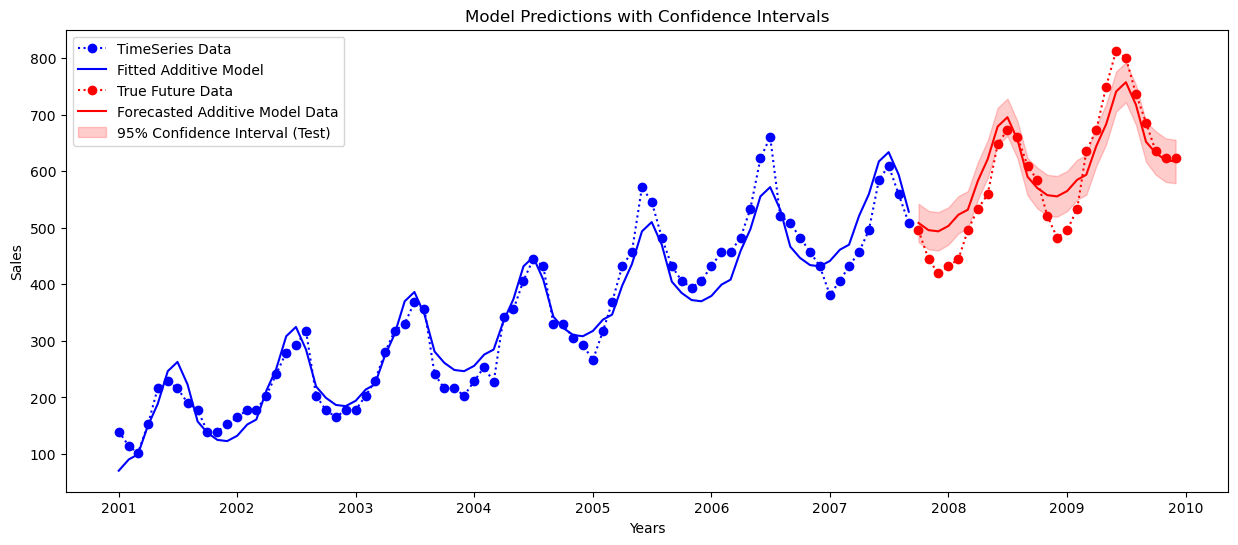

         Years  Sales month_name  index_mesure  April  August  December  \
0   2001-01-01  139.7    January             0  False   False     False   
1   2001-02-01  114.3   February             1  False   False     False   
2   2001-03-01  101.6      March             2  False   False     False   
3   2001-04-01  152.4      April             3   True   False     False   
4   2001-05-01  215.9        May             4  False   False     False   
..         ...    ...        ...           ...    ...     ...       ...   
103 2009-08-01  736.6     August           103  False    True     False   
104 2009-09-01  685.5  September           104  False   False     False   
105 2009-10-01  635.0    October           105  False   False     False   
106 2009-11-01  622.3   November           106  False   False     False   
107 2009-12-01  622.3   December           107  False   False      True   

     February  January   July   June  March    May  November  October  \
0       False     True  Fa

In [18]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

class DataPreparation:
    def __init__(self, csv_path):
        self.dataset_df = pd.read_csv(csv_path)
        self.dataset_df["Years"] = pd.to_datetime(self.dataset_df["Years"])
        self.prepare_data()

    def prepare_data(self):
        self.dataset_df["month_name"] = self.dataset_df["Years"].dt.month_name()
        number_of_rows = len(self.dataset_df)
        self.dataset_df["index_mesure"] = np.arange(0, number_of_rows, 1)

        month_dummies = pd.get_dummies(self.dataset_df['month_name'])
        self.dataset_df = pd.concat([self.dataset_df, month_dummies], axis=1)

        dataset_train_df = self.dataset_df.iloc[:int(number_of_rows * 0.75)]
        dataset_test_df = self.dataset_df.iloc[int(number_of_rows * 0.75):]

        self.x_train = dataset_train_df[['index_mesure'] + list(month_dummies.columns)].values.astype(float)
        self.y_train = dataset_train_df[['Sales']].values

        self.x_test = dataset_test_df[['index_mesure'] + list(month_dummies.columns)].values.astype(float)
        self.y_test = dataset_test_df[['Sales']].values

class Additif:
    def __init__(self, data_preparation_object):
        self.data_preparation_object = data_preparation_object
        self.model = LinearRegression()

        self.model.fit(data_preparation_object.x_train, data_preparation_object.y_train)

        x_train_with_intercept = sm.add_constant(data_preparation_object.x_train)
        self.stats_model = sm.OLS(data_preparation_object.y_train, x_train_with_intercept).fit()

        y_train_predicted = self.model.predict(data_preparation_object.x_train)
        mean_train_absolute_error = np.mean(np.abs(y_train_predicted - data_preparation_object.y_train))
        print(f"On the training set: Mean Absolute Error = {mean_train_absolute_error:.2f}")

        y_test_predicted = self.model.predict(data_preparation_object.x_test)
        mean_test_absolute_error = np.mean(np.abs(y_test_predicted - data_preparation_object.y_test))
        print(f"On the testing set: Mean Absolute Error = {mean_test_absolute_error:.2f}")

        self.show_model_predictions(y_train_predicted, y_test_predicted)

    def show_model_predictions(self, y_train_predicted, y_test_predicted):
        plt.figure(figsize=(15, 6))

        x_train = self.data_preparation_object.dataset_df.iloc[:len(self.data_preparation_object.x_train), :]["Years"]
        plt.plot(x_train, self.data_preparation_object.y_train, "bo:", label="TimeSeries Data")
        plt.plot(x_train, y_train_predicted, "b", label="Fitted Additive Model")

        x_test = self.data_preparation_object.dataset_df.iloc[len(self.data_preparation_object.x_train):, :]["Years"]
        plt.plot(x_test, self.data_preparation_object.y_test, "ro:", label="True Future Data")
        plt.plot(x_test, y_test_predicted, "r", label="Forecasted Additive Model Data")

        ci_test = self.stats_model.get_prediction(sm.add_constant(self.data_preparation_object.x_test)).conf_int()

        plt.fill_between(x_test, ci_test[:, 0], ci_test[:, 1], color='red', alpha=0.2, label="95% Confidence Interval (Test)")

        plt.xlabel('Years')
        plt.ylabel('Sales')
        plt.title('Model Predictions with Confidence Intervals')
        plt.legend()
        plt.show()

csv_path = "vente_maillots_de_bain.csv"
data_prep = DataPreparation(csv_path)
additif = Additif(data_prep)
print(data_prep.dataset_df)
